# Lecture 09 - *k*-Nearest Neighbor

***
##### CS 434 - Dating Mining and Machine Learning
##### Oregon State University-Cascades
***

<img src=https://cdn-images-1.medium.com/max/800/0*uNbO79MrS7jvY4qp.png width="500">

<img src=http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png width="500">

## <img src="https://img.icons8.com/color/32/000000/fork-lift.png"/> Load packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pydotplus import graph_from_dot_data
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from math import sqrt
%matplotlib inline

### <img src="https://img.icons8.com/color/24/000000/cosine.png"/> Helper function for graphing our results

In [0]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## <img src="https://img.icons8.com/color/32/000000/accept-database.png"/> Prepare a dataset

### <img src="https://img.icons8.com/color/32/000000/database-restore.png"/>  Load the data

Load the Iris dataset from scikit-learn. 

In [0]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
print(df)

     sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                  5.1               3.5  ...               0.2     0.0
1                  4.9               3.0  ...               0.2     0.0
2                  4.7               3.2  ...               0.2     0.0
3                  4.6               3.1  ...               0.2     0.0
4                  5.0               3.6  ...               0.2     0.0
..                 ...               ...  ...               ...     ...
145                6.7               3.0  ...               2.3     2.0
146                6.3               2.5  ...               1.9     2.0
147                6.5               3.0  ...               2.0     2.0
148                6.2               3.4  ...               2.3     2.0
149                5.9               3.0  ...               1.8     2.0

[150 rows x 5 columns]


### <img src="https://img.icons8.com/color/32/000000/search-property.png"/>  Examine the data

The classes are integer labels where 
* 0=Iris-Setosa
* 1=Iris-Versicolor
* 2=Iris-Virginica.

In [0]:
# split X and y
X = iris.data
print('X shape', X.shape)
y = iris.target
print('y shape', y.shape)
print('Class labels:', np.unique(y))

X shape (150, 4)
y shape (150,)
Class labels: [0 1 2]


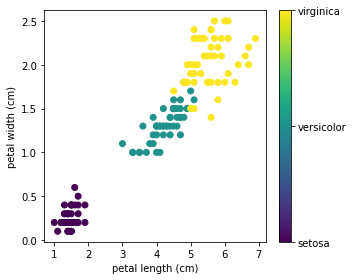

In [0]:
# compare two features
x_index = 2   # petal length
y_index = 3   # petal width

formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.figure(figsize=(5, 4))
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.tight_layout()
plt.show()

### <img src="https://img.icons8.com/color/32/000000/hashtag-activity-feed-2.png"/>  Get attributes and class labels

In [0]:
# consider only the third column of the petal length, and 
# the fourth column of petal width of the flower. 
X = iris.data[:, [2, 3]]
y = iris.target

### <img src="https://img.icons8.com/color/32/000000/split-files.png"/> Split into train and test sets

In this example, 70% is for training and 30% is for testing.

In [0]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

# examine label
print('Label counts in y:', np.bincount(y))
print('Label counts in y_train:', np.bincount(y_train))
print('Label counts in y_test:', np.bincount(y_test))

Label counts in y: [50 50 50]
Label counts in y_train: [35 35 35]
Label counts in y_test: [15 15 15]


### <img src="https://img.icons8.com/color/32/000000/compare.png"/> Standardize the features

In [0]:
# standardize features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# needed for graphing
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# <img src="https://img.icons8.com/color/32/000000/ruler.png"/>  Distance Metrics

## <img src="https://img.icons8.com/color/32/000000/radar-plot.png"/> Euclidean distance

The Euclidean distance is a distance measure between two points or or vectors in a two- or multidimensional (Euclidean) space based on Pythagoras' theorem. The distance is calculated by taking the square root of the sum of the squared pair-wise distances of every dimension.

$$\sqrt{\sum_{i=1}^n (x_i-y_i)^2}$$

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Euclidean_distance_3d_2_cropped.png/736px-Euclidean_distance_3d_2_cropped.png width="500">

## <img src="https://img.icons8.com/color/32/000000/blockchain-technology.png"/>  Manhattan distance

The Manhattan distance (sometimes also called Taxicab distance) metric is related to the Euclidean distance, but instead of calculating the shortest diagonal path ("beeline") between two points, it calculates the distance based on gridlines. The Manhattan distance was named after the block-like layout of the streets in Manhattan.

$$\sum_{i=1}^n |x_i-y_i|$$


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/283px-Manhattan_distance.svg.png)

The red, blue, and yellow lines all have the same length (12), whereas the green line (Euclidean) has length $\sqrt {72}\approx 8.4853$.

## <img src="https://img.icons8.com/color/32/000000/m.png"/> Minkowski distance

The Minkowski distance is a generalized form of the Euclidean distance (if $p=2$) and the Manhattan distance (if $p=1$).

$$\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$$

## <img src="https://img.icons8.com/color/32/000000/c.png"/> Chebyshev distance

The Chebyshev distance measures the distance between two vectors as the greatest of their differences along any coordinate dimension.

$$\lim_{p\rightarrow \infty} \left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p} \ = \ \max_i(|x_i-y_i|)$$

![alt text](https://wargamingmiscellanybackup.files.wordpress.com/2017/08/38924-distances31-08-17-02.jpg?w=400&h=400)

# <img src="https://img.icons8.com/color/32/000000/neighbor.png"/>  Nearest Neighbors

$k$-nearest neighbors algorithm ($k$-NN) is a non-parametric method used for classification and regression.
* for classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors ($k$ is a positive integer, typically small). If $k$ = 1, then the object is simply assigned to the class of that single nearest neighbor.
* for regression, the output is the property value for the object. This value is the average of the values of $k$ nearest neighbors.

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch03/images/03_23.png width="500">

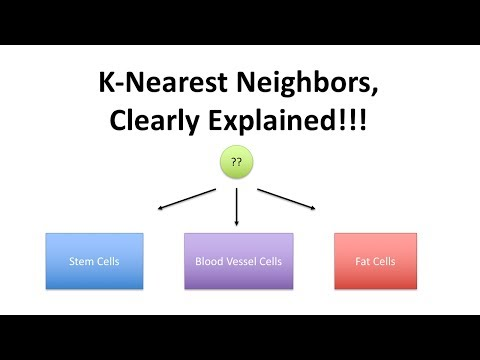

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('HVXime0nQeI')

## <img src="https://img.icons8.com/color/32/000000/k.png"/> *k*-NN classifier

### `KNeighborsClassifer` in `sklearn`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


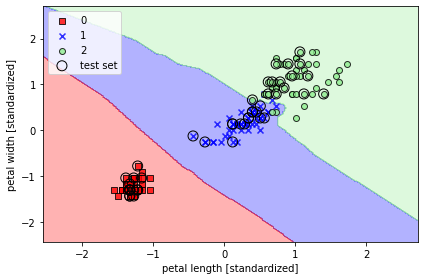

In [0]:
# kNN implementation in sklearn
knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### <img src="https://img.icons8.com/color/32/000000/full-tool-storage-box-.png"/> $k$-NN implementation from scratch

In [0]:
# locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		# skip test_row, train on all others
		if len(set(train_row) & set(test_row)) < 3:
			dist = euclidean_distance(test_row, train_row)
			distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [0]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [0]:
# test data
dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]
dataset

[[2.7810836, 2.550537003, 0],
 [1.465489372, 2.362125076, 0],
 [3.396561688, 4.400293529, 0],
 [1.38807019, 1.850220317, 0],
 [3.06407232, 3.005305973, 0],
 [7.627531214, 2.759262235, 1],
 [5.332441248, 2.088626775, 1],
 [6.922596716, 1.77106367, 1],
 [8.675418651, -0.242068655, 1],
 [7.673756466, 3.508563011, 1]]

In [0]:
# get nearest neighbors for row 0
neighbors = get_neighbors(dataset, dataset[0], 3)

# print three nearest neighbors
for neighbor in neighbors:
	print(neighbor)

[3.06407232, 3.005305973, 0]
[1.465489372, 2.362125076, 0]
[1.38807019, 1.850220317, 0]


# <img src="https://img.icons8.com/color/32/000000/123.png"/> Choosing $k$ ...

There is no best practice to select $k$.  It is a tunable parameter that should be explored using trial and error or through empirical testing. 

* *SMALLER* values of $k$ can be noisy as each neighbor has a high influence on the 
outcome.

* *LARGER* values of $k$ results in smoother decision bounderies, which indicate a lower variance, but increased bias.  Processing large number of neighbors can be computational expensive.

* $k$ should always be an odd value to handle breaking ties.

***
### ... with math
***

One strategy is to select
$$ k = \sqrt{N}$$
where $N$ is the number of samples in the training set.

***
### ... with cross-validation
***

Extract a small validation set from the training set. Create a model for various values of $k = {1, 2, 3, ... }$.  Evaluate the model using the validation set. Select the $k$ with the lowest validation error to use in the experiment. 

## <img src="https://img.icons8.com/color/32/000000/grid.png"/> Grid search

In [0]:
# set grid parameters
grid_params = {
    'n_neighbors' : list(range(1, 21, 2)),
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan','chebyshev']
}

# construct a grid search 
gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

# run the grid search
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.2s finished


In [0]:
# see the best score
print(gs_results.best_score_)

0.9619047619047619


In [0]:
# see the best algorithm
print(gs_results.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [0]:
# see the best parameters
print(gs_results.best_params_)

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


![alt text](https://imgs.xkcd.com/comics/efficiency.png)